# Changing the base distribution of a flow model

This example shows how one can easily change the base distribution with our API.
First, let's look at how the normalizing flow can learn a two moons target distribution with a Gaussian distribution as the base.

In [1]:
# Import packages
import torch
import numpy as np

import normflows as nf

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from tqdm import tqdm

# Setting up a flow model with a 2D Gaussian base distribution

In [2]:
# Set up model

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
num_layers = 32
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 64, 64, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# Construct flow model
model = nf.NormalizingFlow(base, flows)

In [3]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

In [4]:
# Define target distribution
target = nf.distributions.TwoMoons()

C:\Users\kanha\anaconda3\envs\ml_env\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


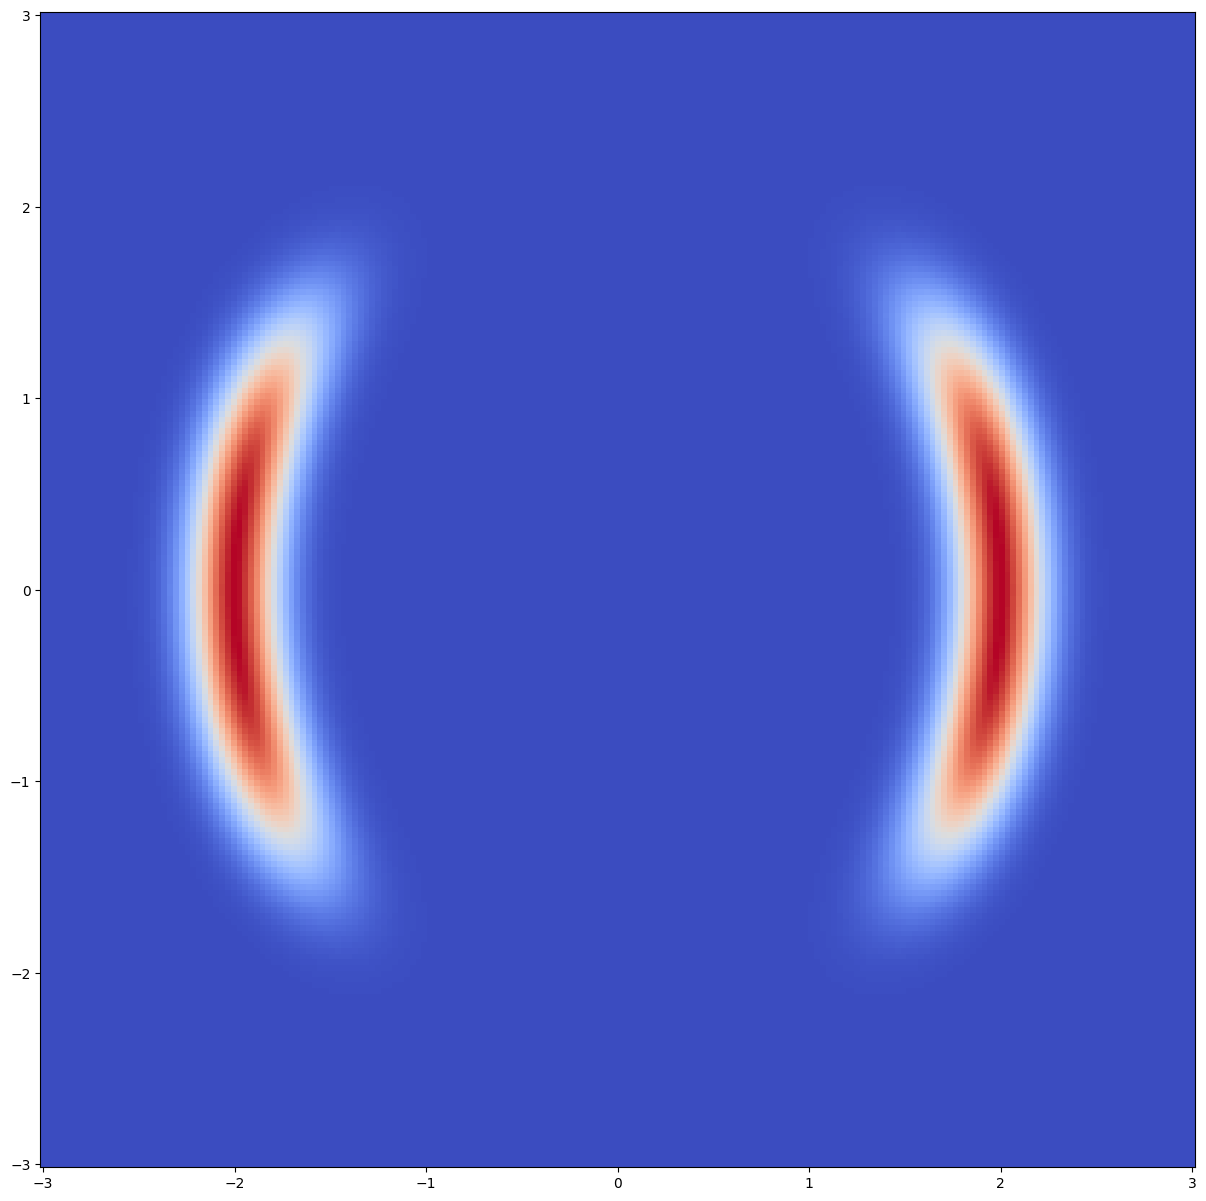

In [5]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()

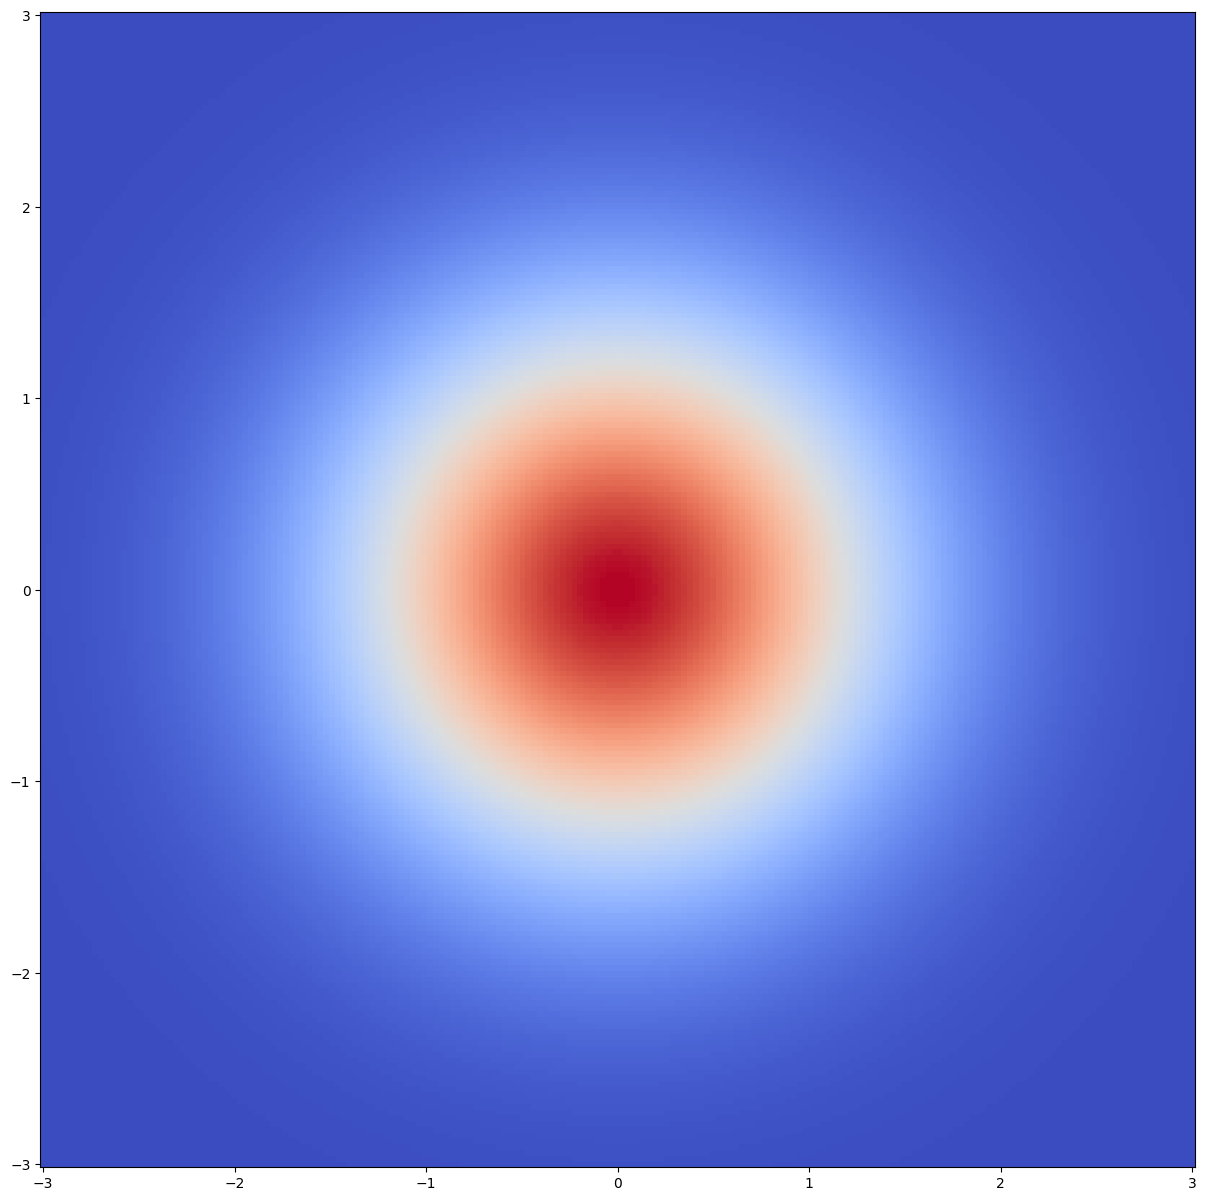

In [6]:
# Plot initial flow distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()

## Training the model

 12%|█▏        | 498/4000 [00:33<03:34, 16.35it/s]

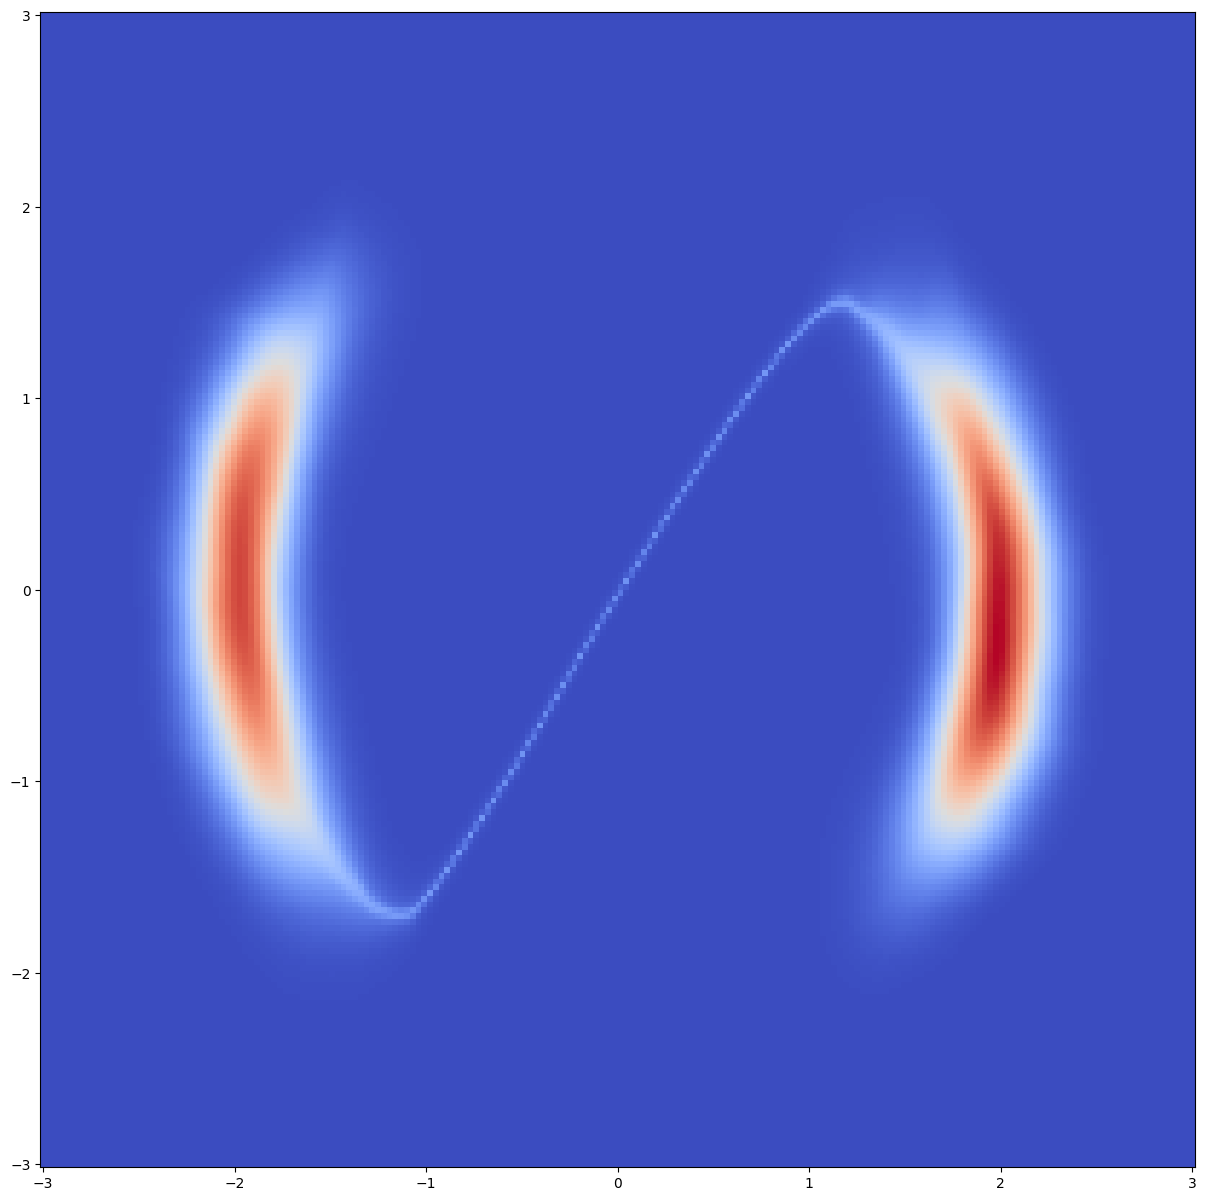

 25%|██▍       | 998/4000 [01:13<03:34, 13.97it/s]

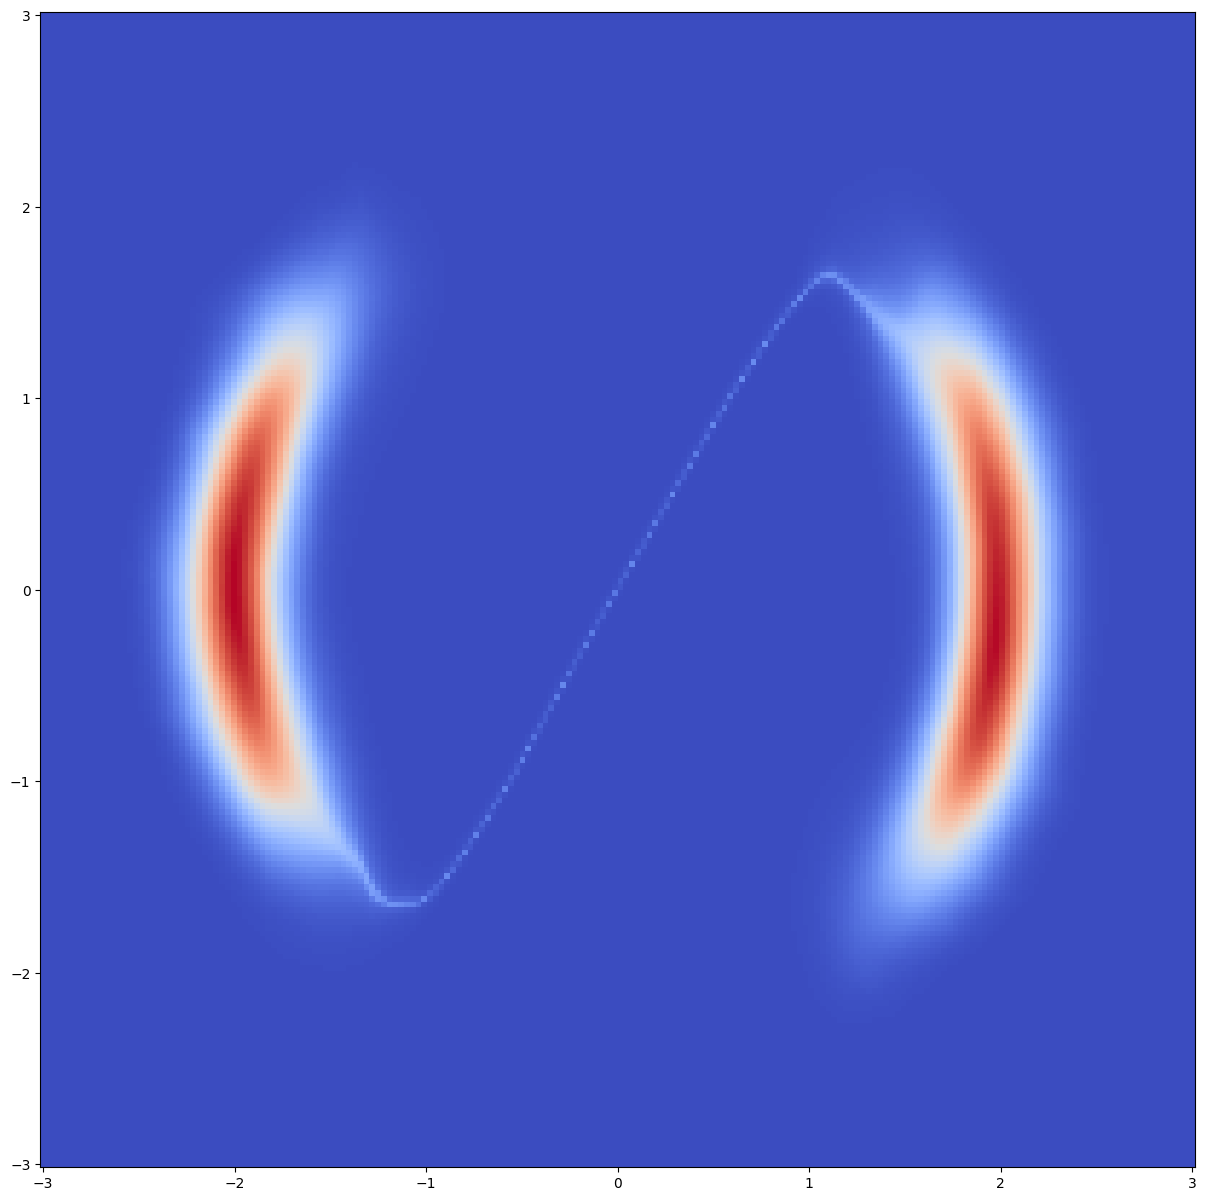

 37%|███▋      | 1499/4000 [01:53<06:03,  6.88it/s]

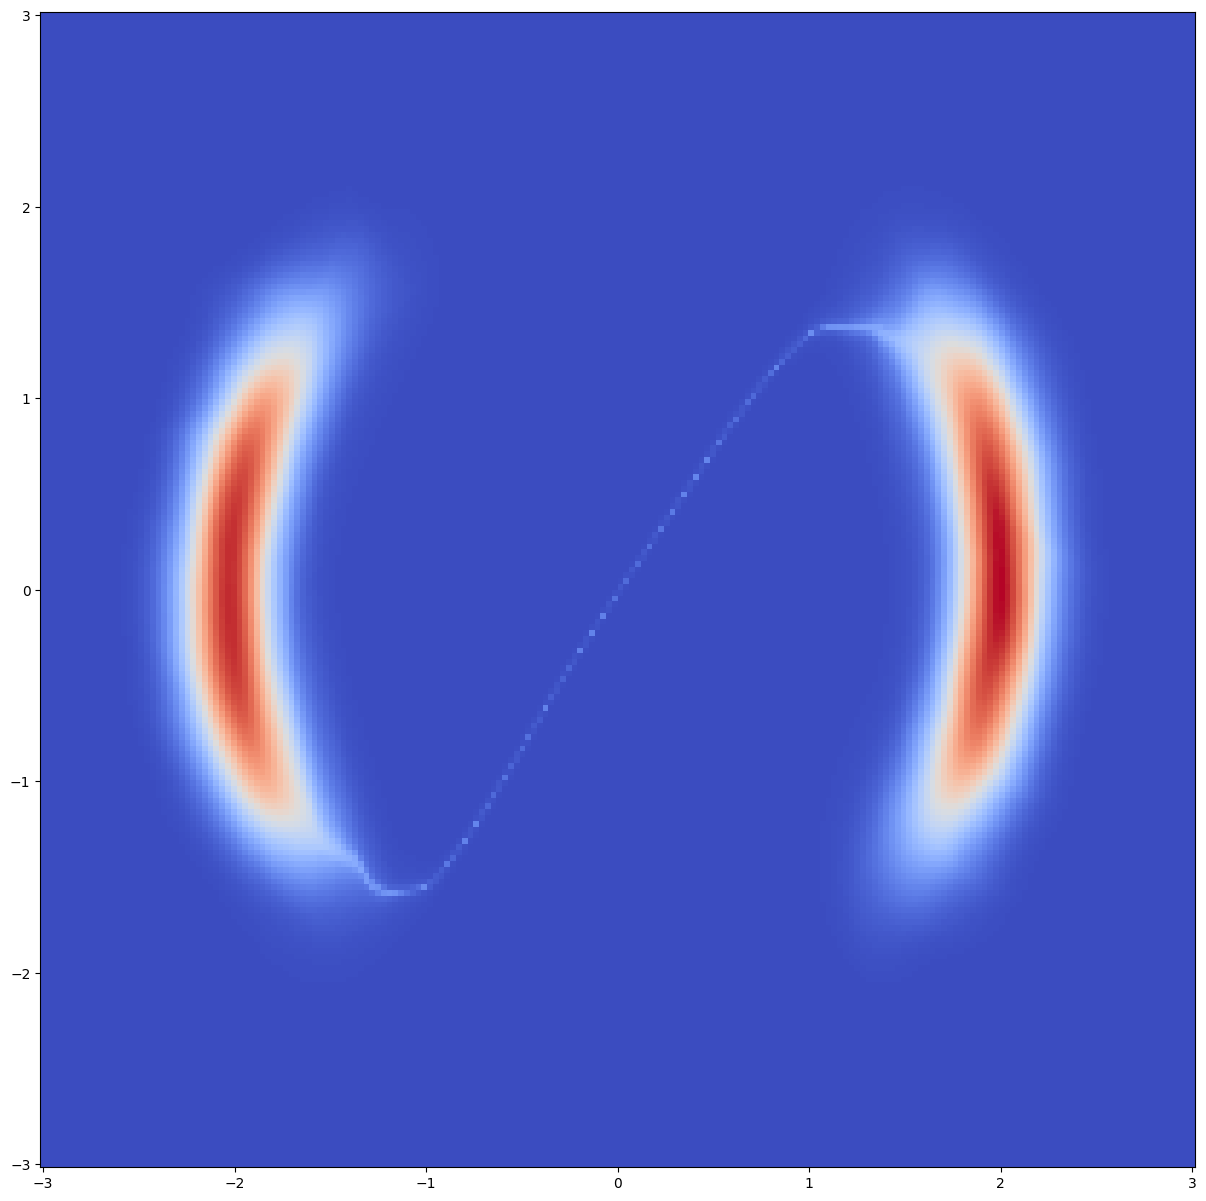

 50%|████▉     | 1998/4000 [02:37<02:50, 11.71it/s]

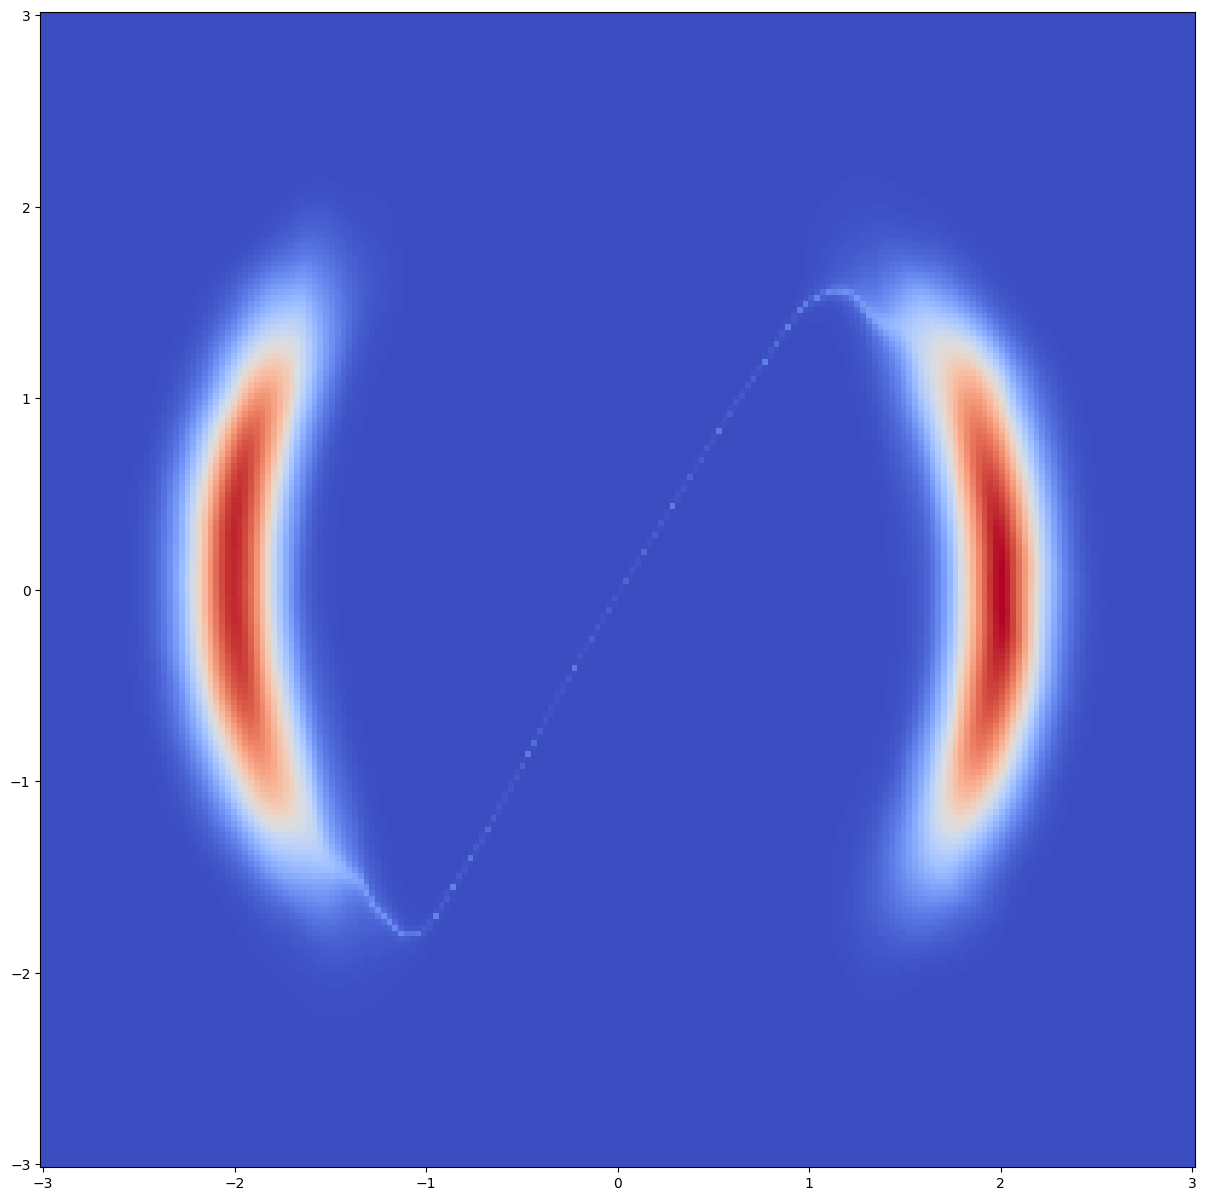

 62%|██████▏   | 2499/4000 [03:33<02:41,  9.31it/s]

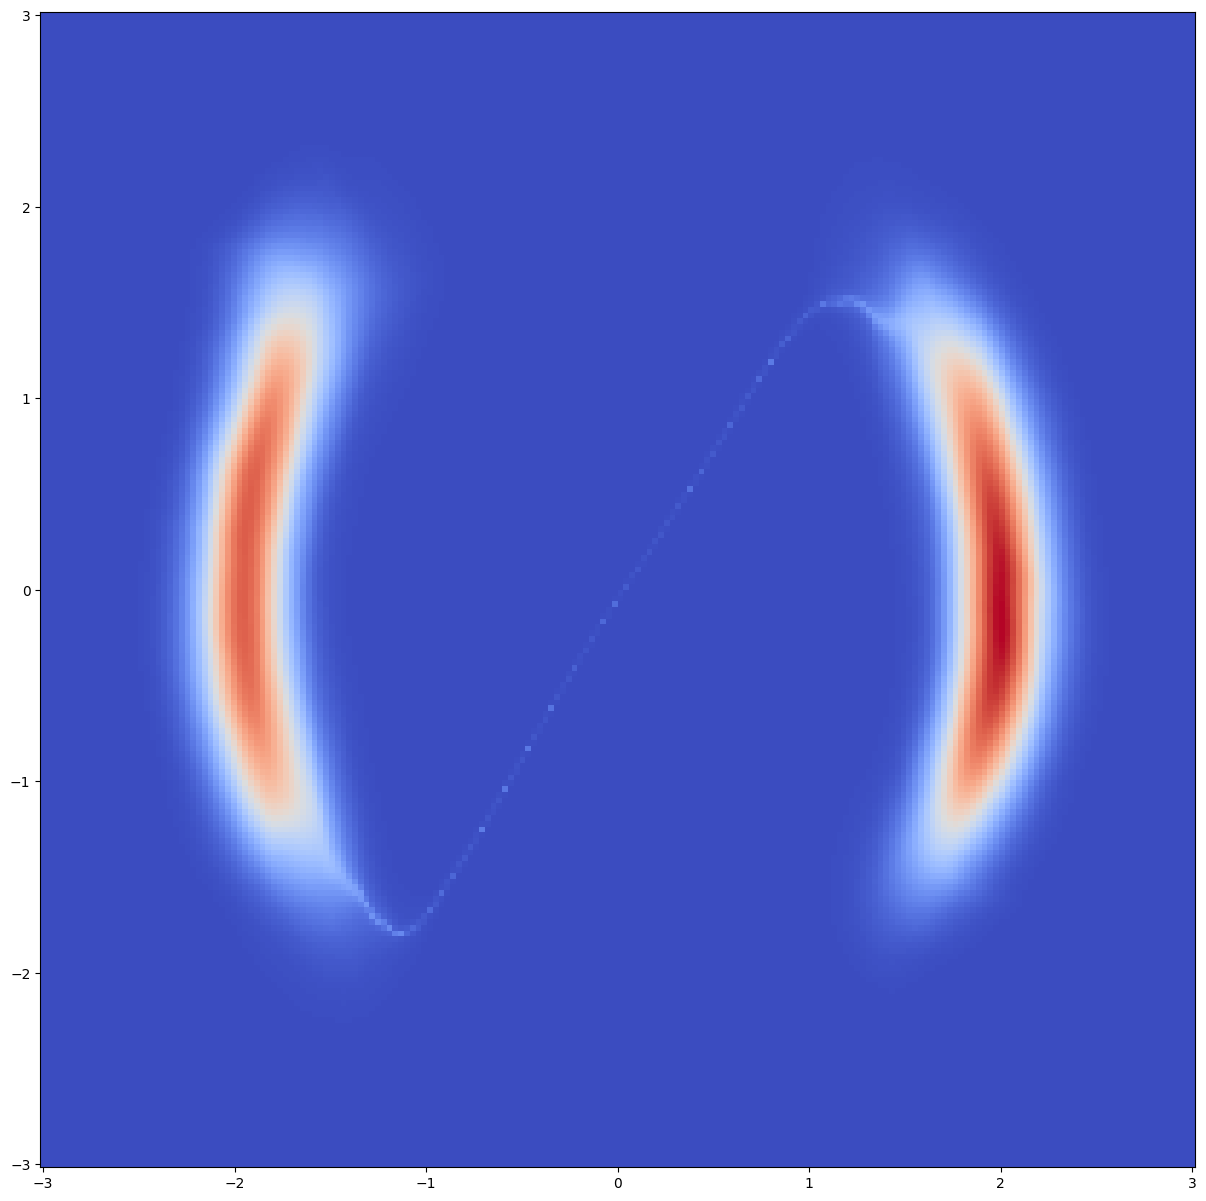

 75%|███████▍  | 2998/4000 [04:27<01:46,  9.40it/s]

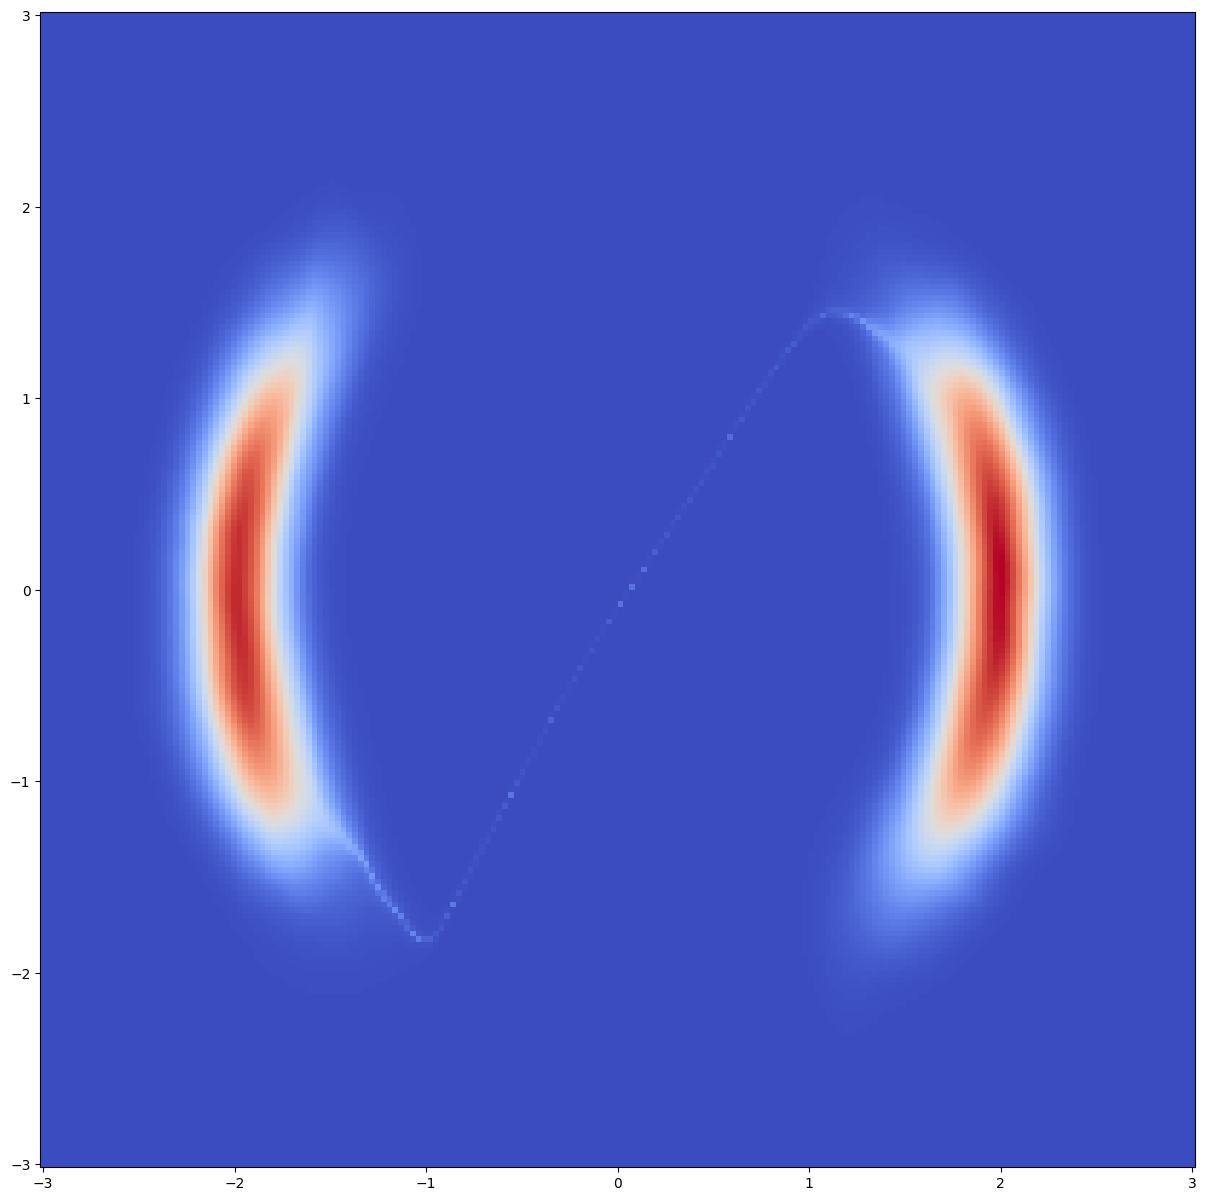

 87%|████████▋ | 3499/4000 [05:24<00:54,  9.14it/s]

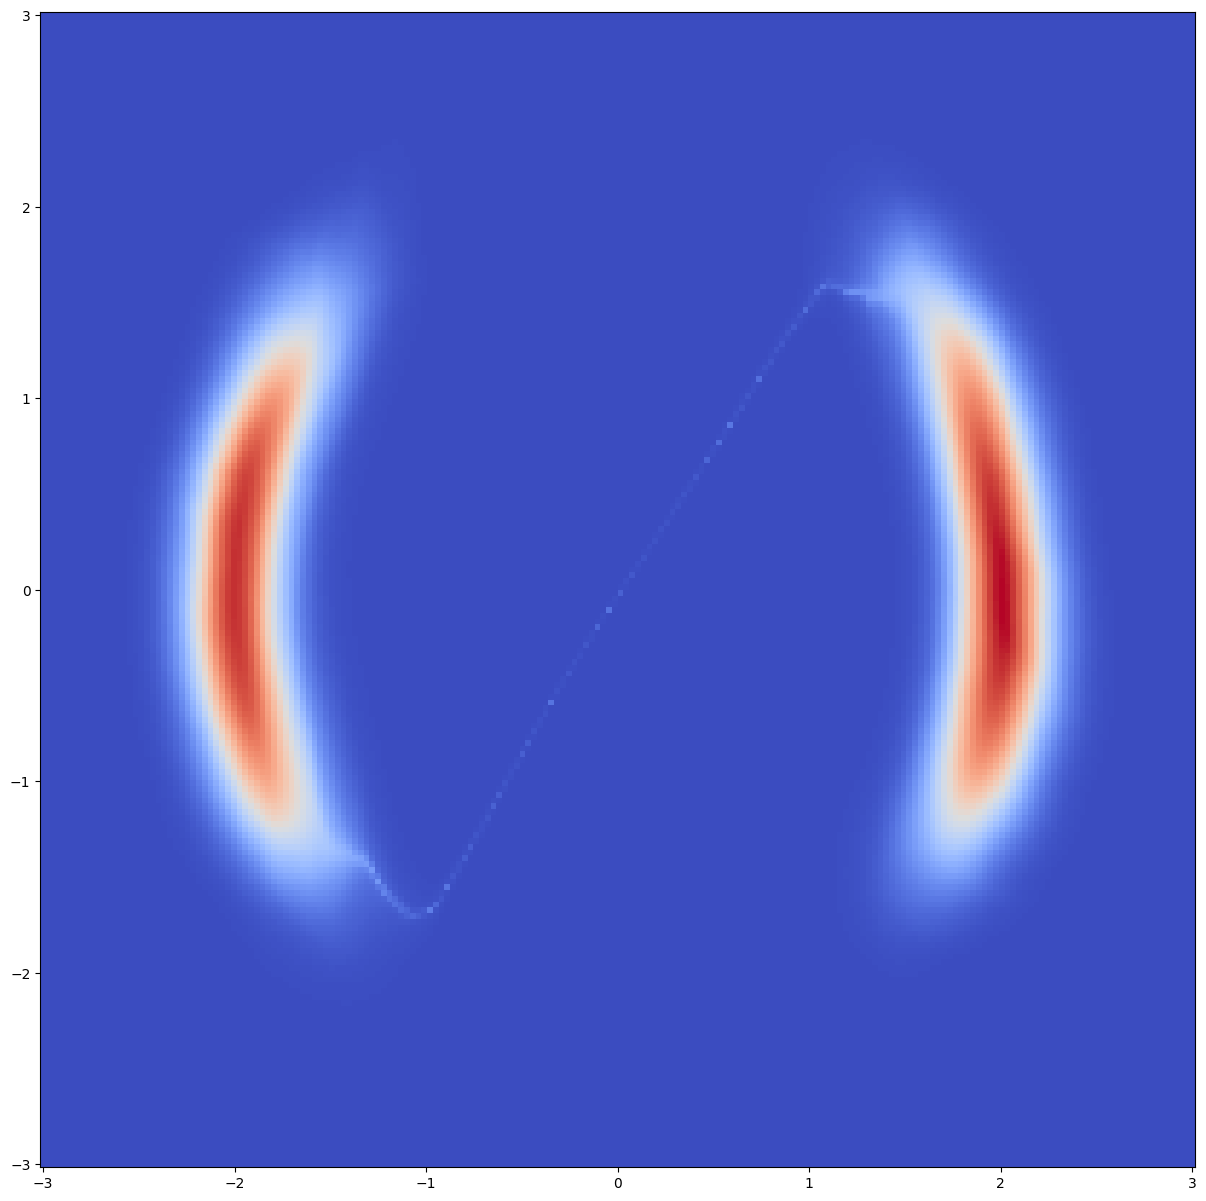

100%|█████████▉| 3998/4000 [06:20<00:00, 11.11it/s]

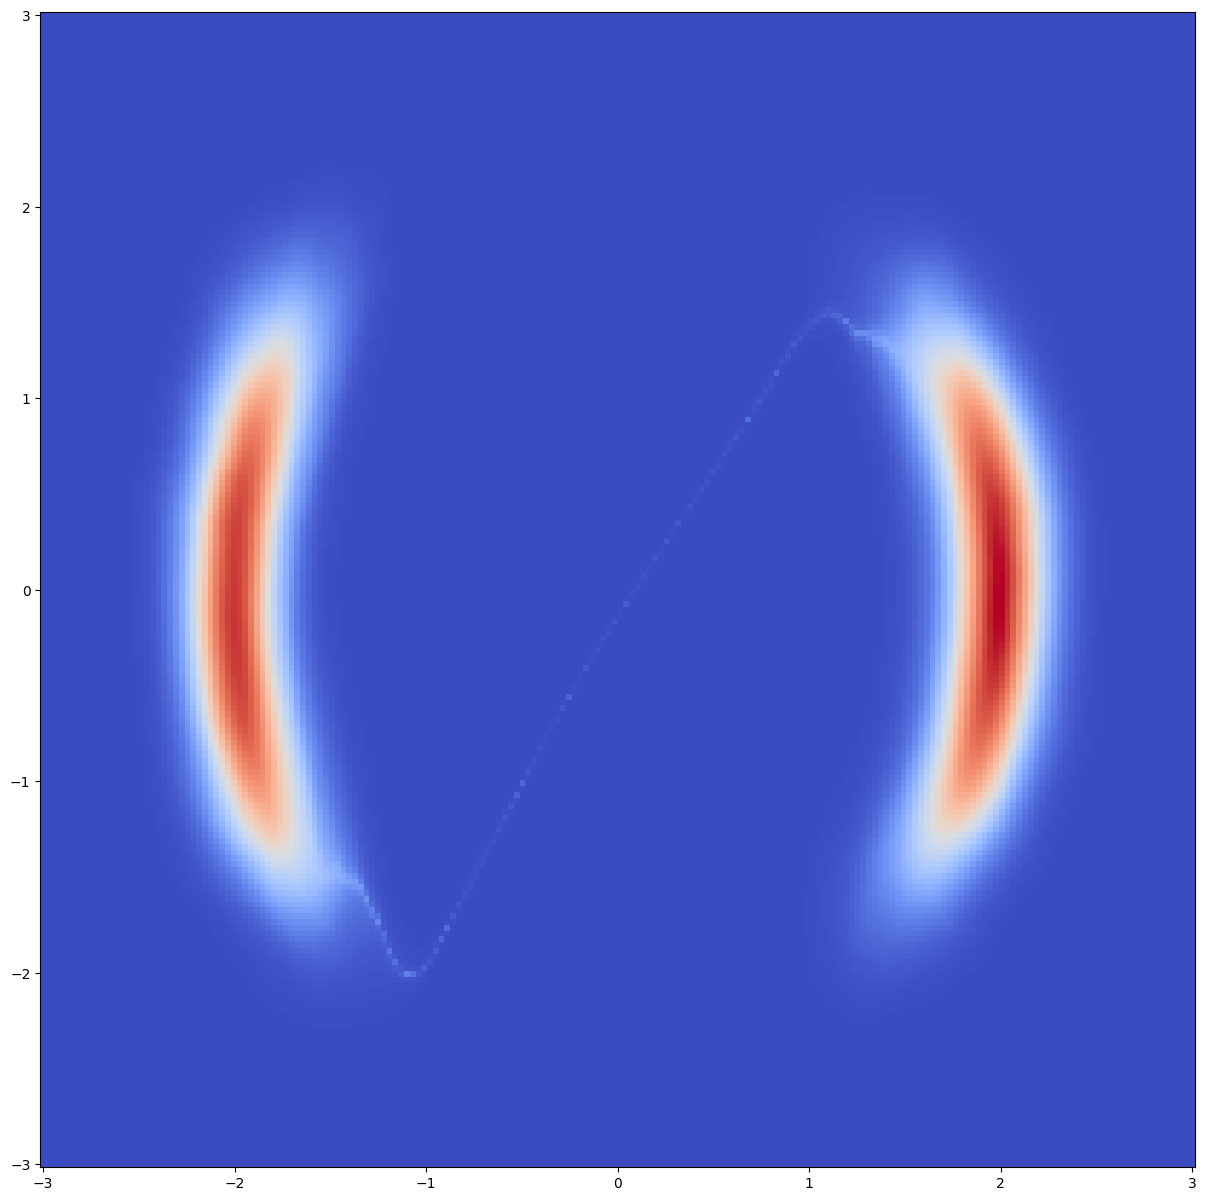

100%|██████████| 4000/4000 [06:21<00:00, 10.49it/s]


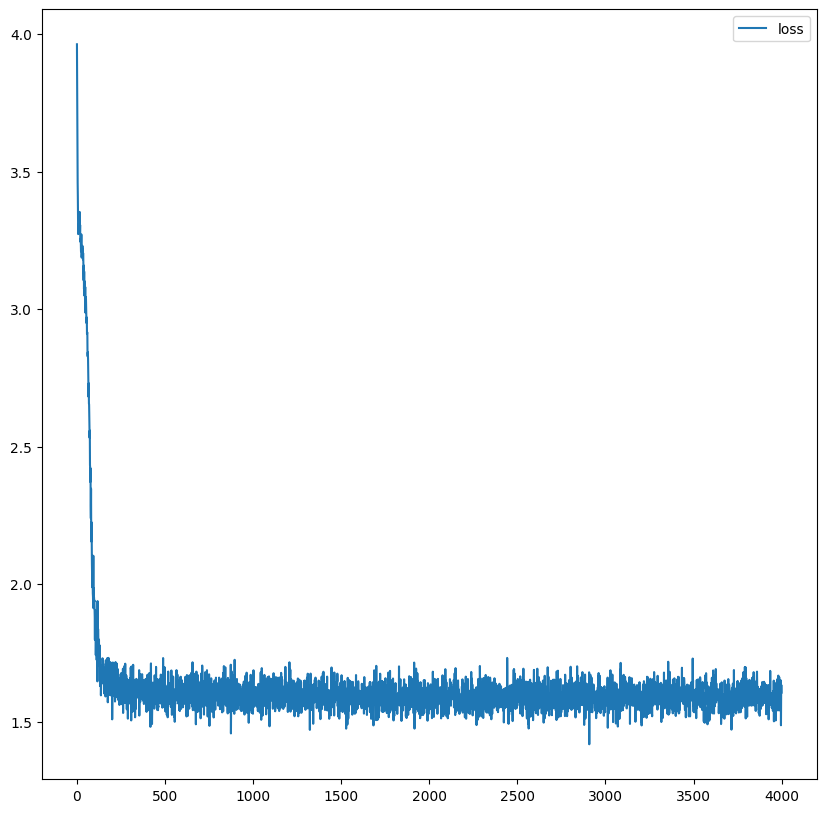

In [7]:
# Train model
max_iter = 4000
num_samples = 2 ** 9
show_iter = 500


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    x = target.sample(num_samples).to(device)
    
    # Compute loss
    loss = model.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

## Visualizing the learned distribution

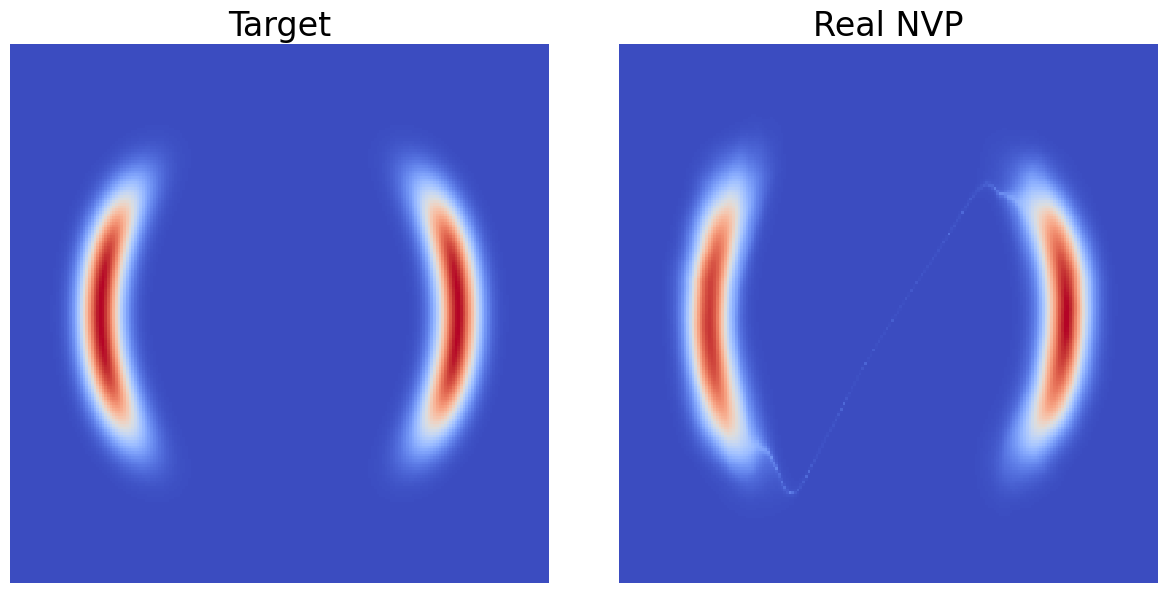

In [8]:
# Plot target distribution
f, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 7))

log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[0].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[0].set_aspect('equal', 'box')
ax[0].set_axis_off()
ax[0].set_title('Target', fontsize=24)

# Plot learned distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[1].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[1].set_aspect('equal', 'box')
ax[1].set_axis_off()
ax[1].set_title('Real NVP', fontsize=24)

plt.subplots_adjust(wspace=0.1)

plt.show()

Notice there is a bridge between the two modes of the learned target.
This is not a big deal usually since the bridge is really thin, and going to higher dimensional space will make it expoentially unlike to have samples within the bridge.
However, we can see the shape of each mode is also a bit distorted.
So it would be nice to get rid of the bridge. Now let's try to use a Gaussian mixture distribution as our base distribution, instead of a single Gaussian.

# Use a Gaussian mixture model as the base instead

In [10]:
# Set up model

# Define a mixture of Gaussians with 2 modes.
base = nf.distributions.base.GaussianMixture(2,2, loc=[[-2,0],[2,0]],scale=[[0.3,0.3],[0.3,0.3]])

# Define list of flows
num_layers = 32
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 64, 64, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# Construct flow model
model = nf.NormalizingFlow(base, flows)#.cuda()

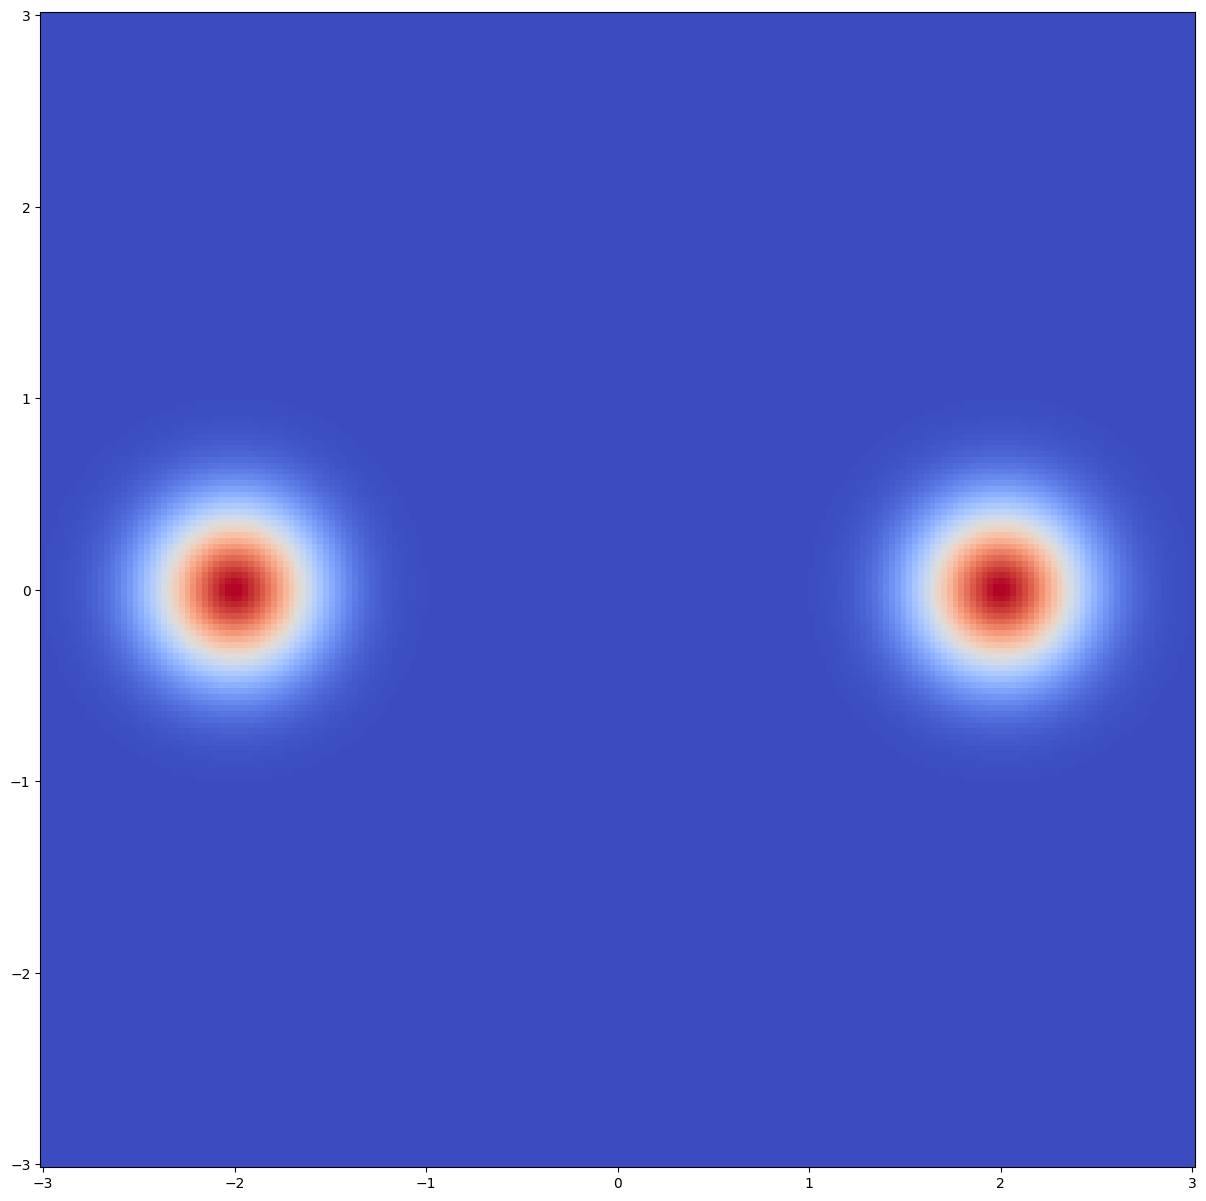

In [11]:
# Plot initial flow distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()

## Train the new model

 12%|█▏        | 499/4000 [00:35<05:03, 11.54it/s]

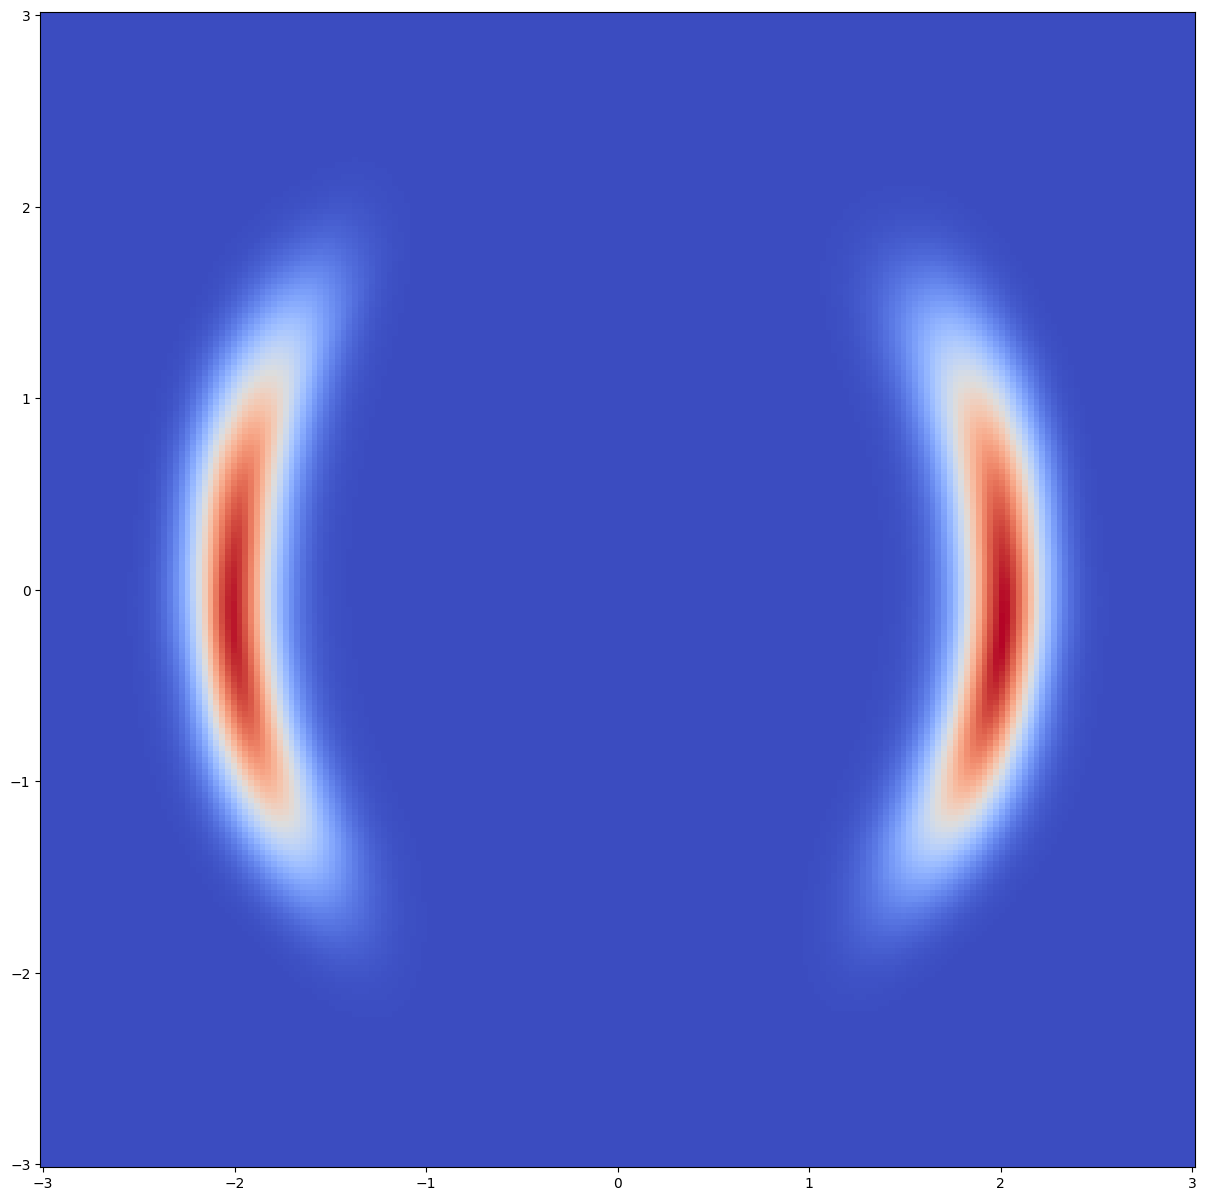

 25%|██▍       | 999/4000 [01:45<06:43,  7.44it/s]

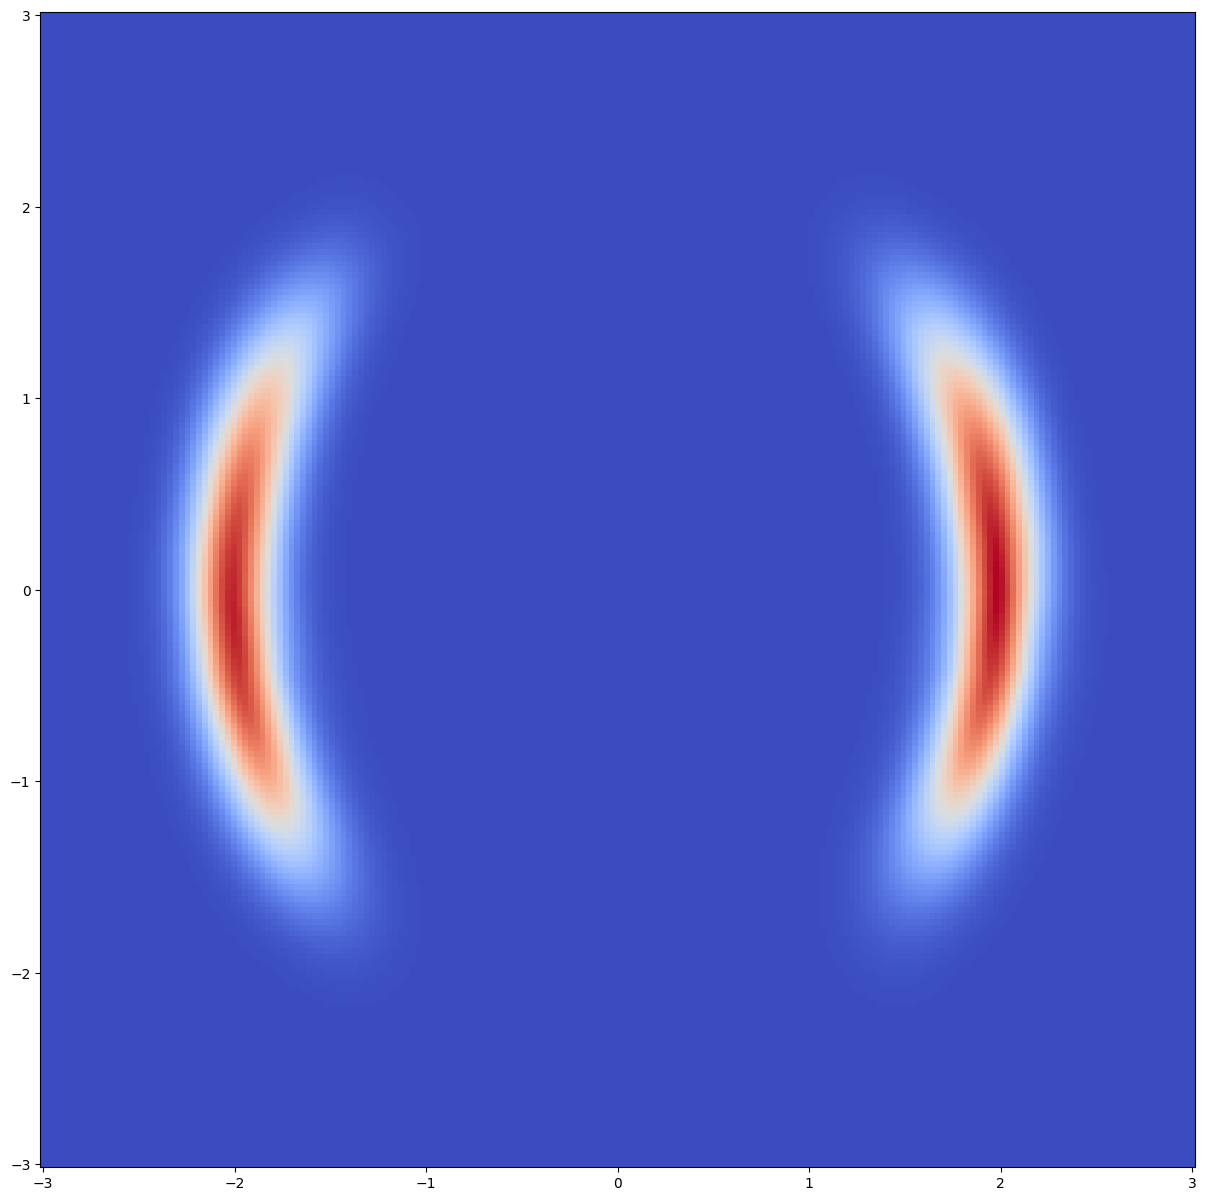

 37%|███▋      | 1499/4000 [02:59<05:04,  8.21it/s]

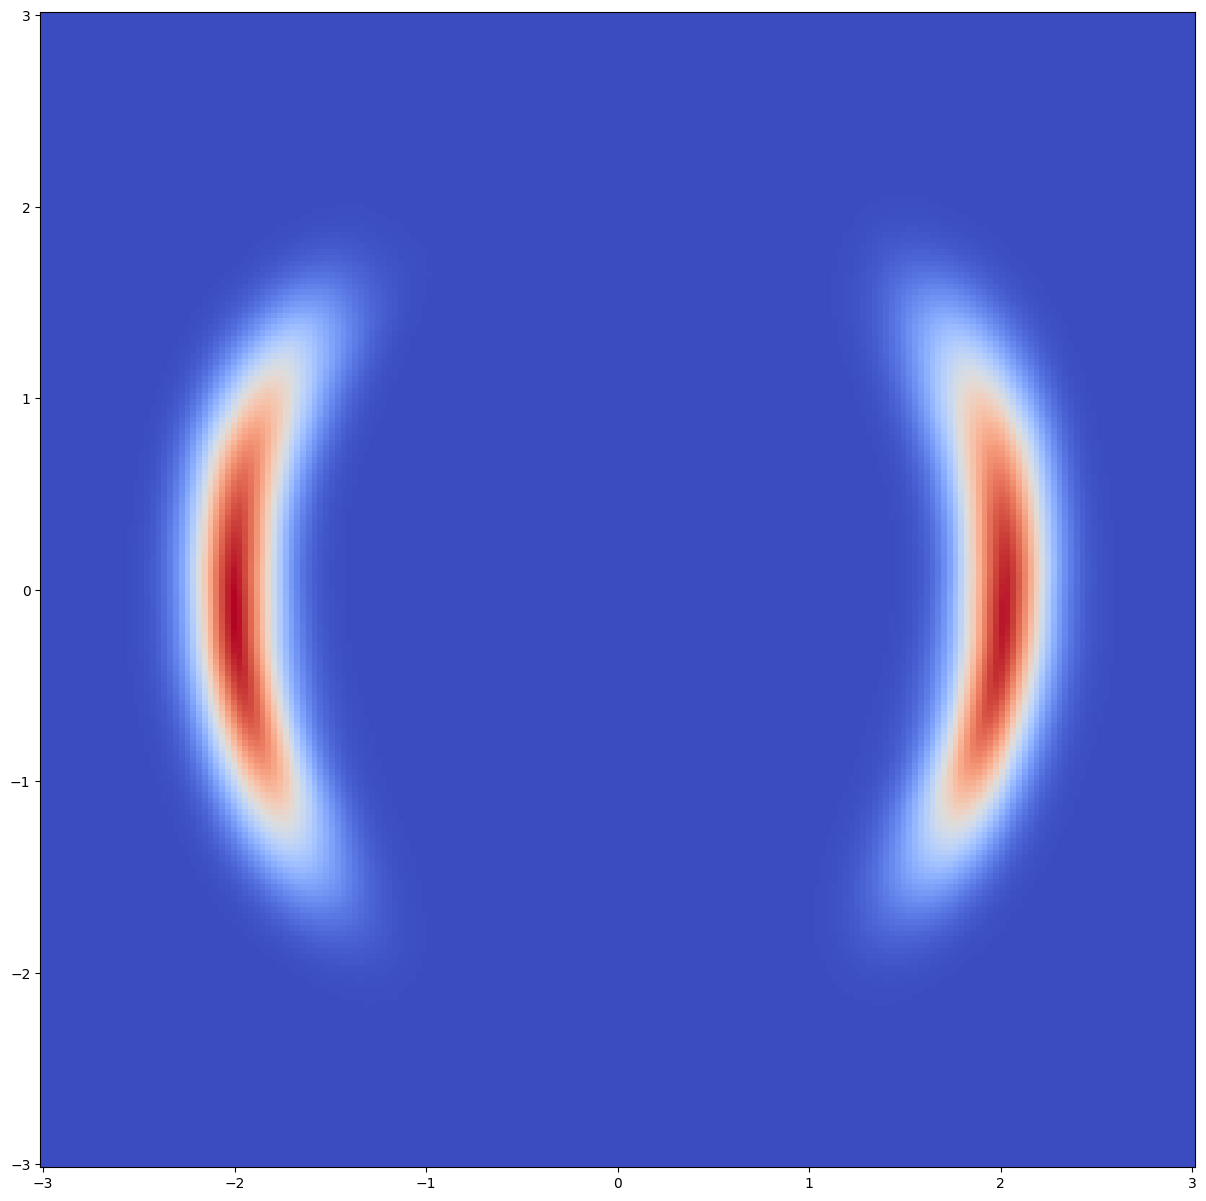

 50%|████▉     | 1999/4000 [04:17<04:53,  6.81it/s]

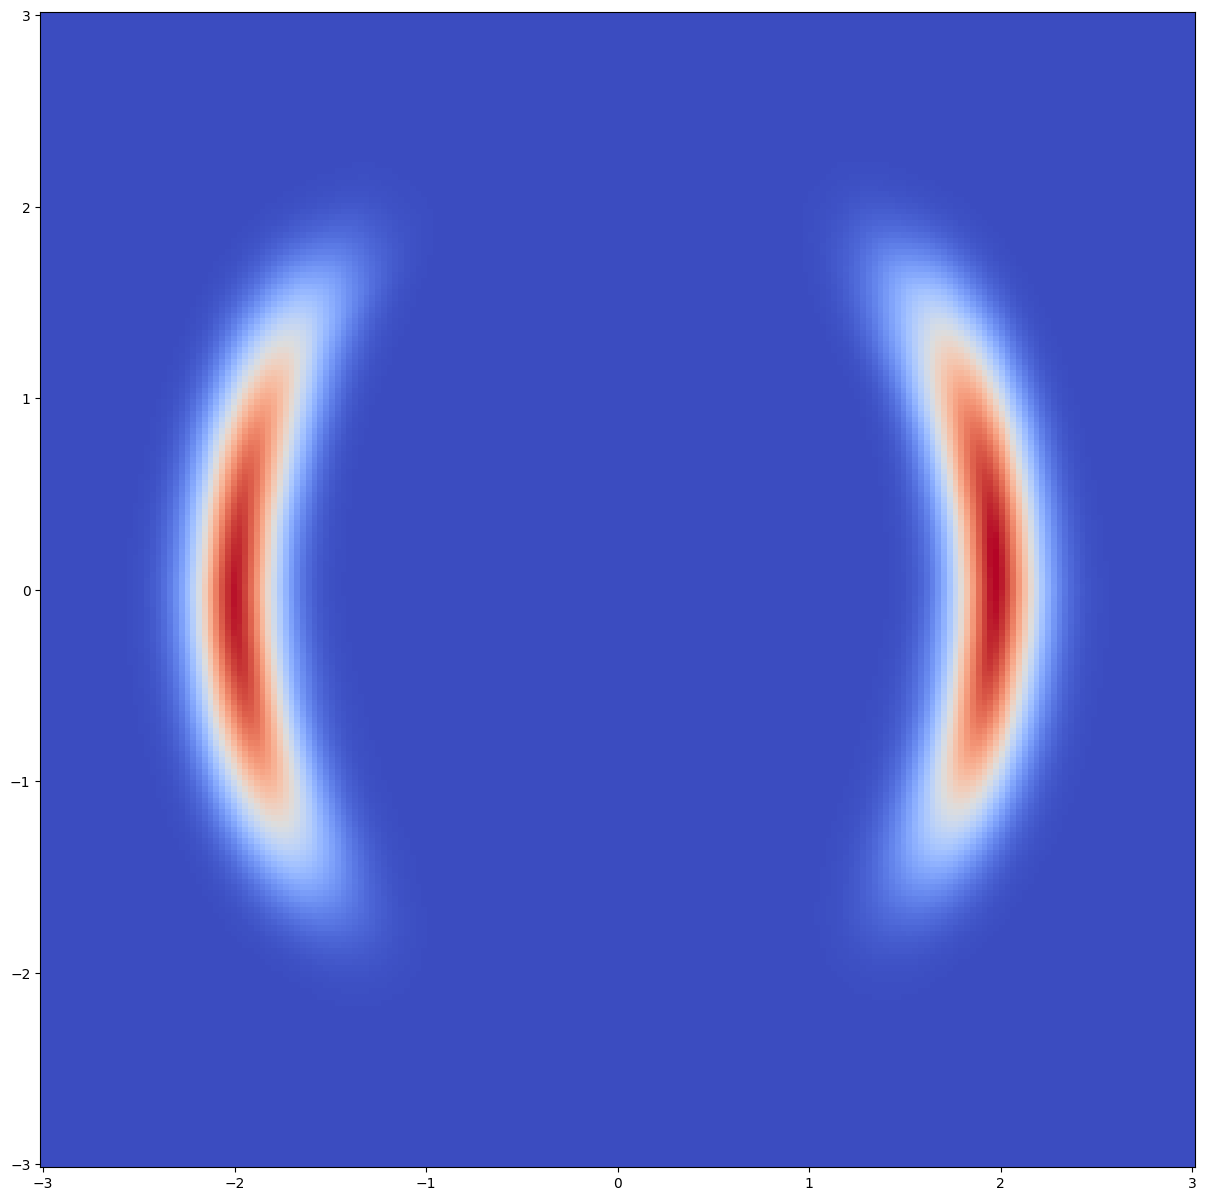

 62%|██████▏   | 2499/4000 [05:50<04:31,  5.53it/s]

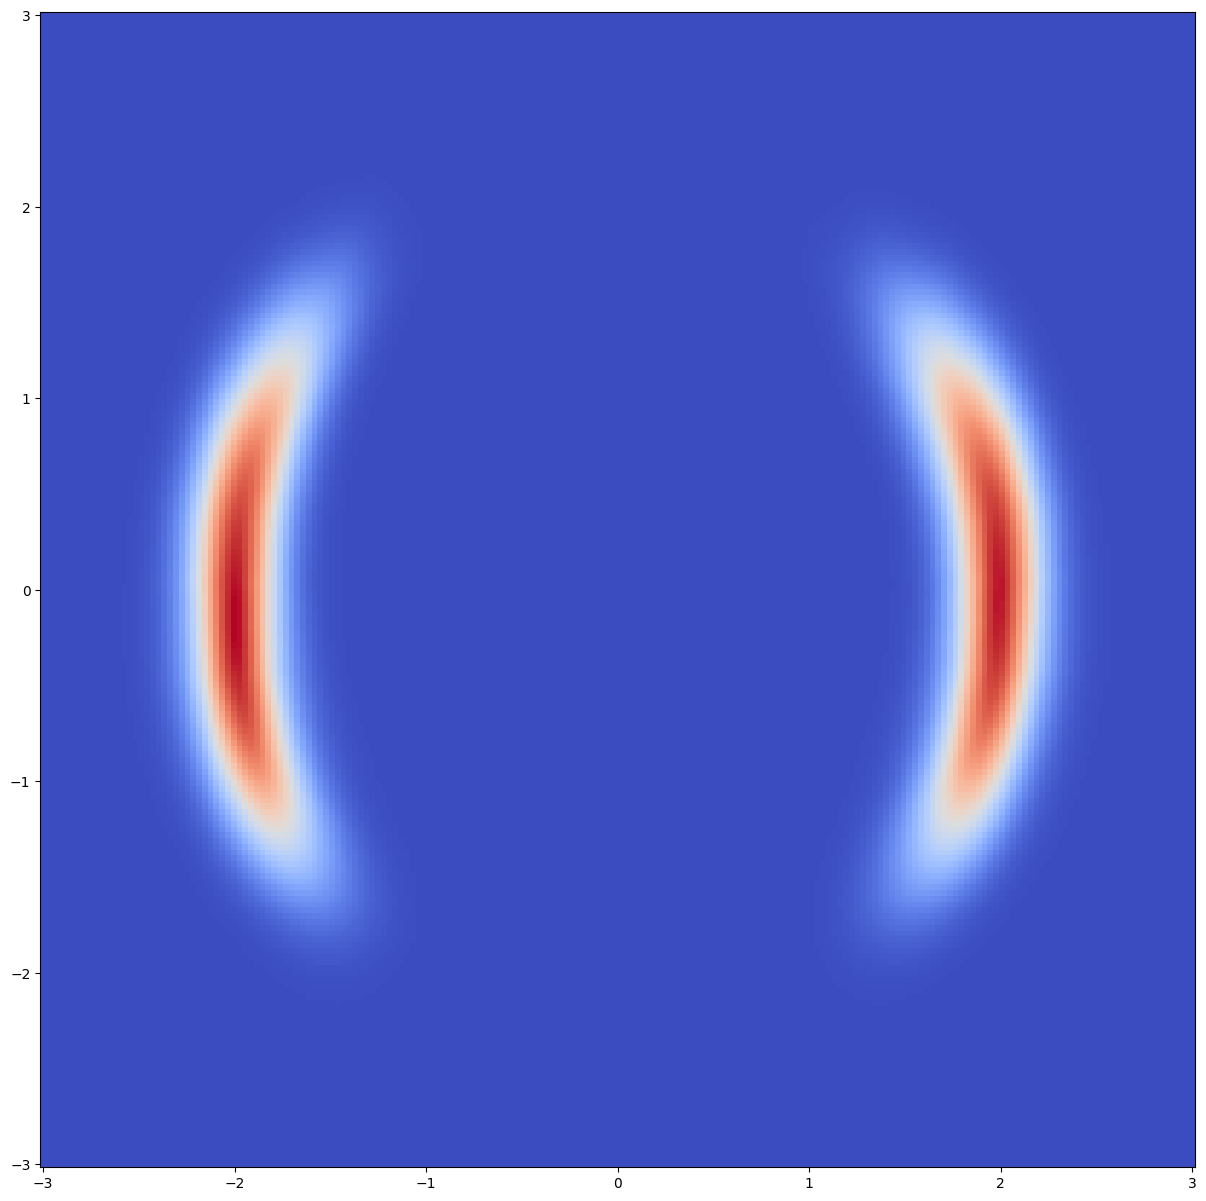

 75%|███████▍  | 2999/4000 [07:20<02:37,  6.37it/s]

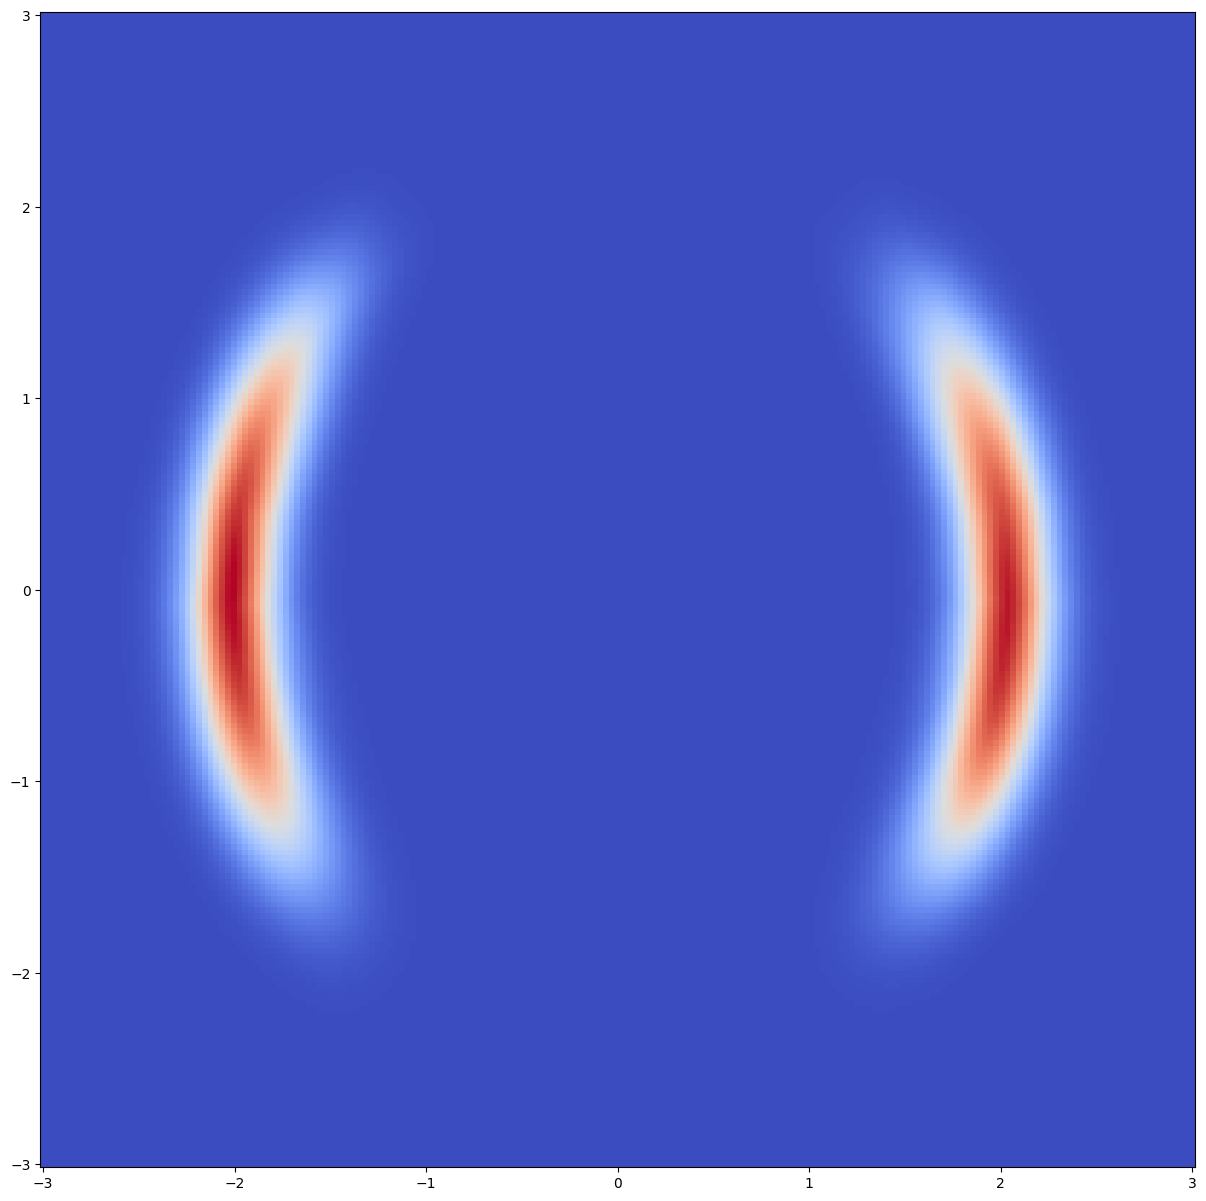

 87%|████████▋ | 3499/4000 [08:48<01:15,  6.65it/s]

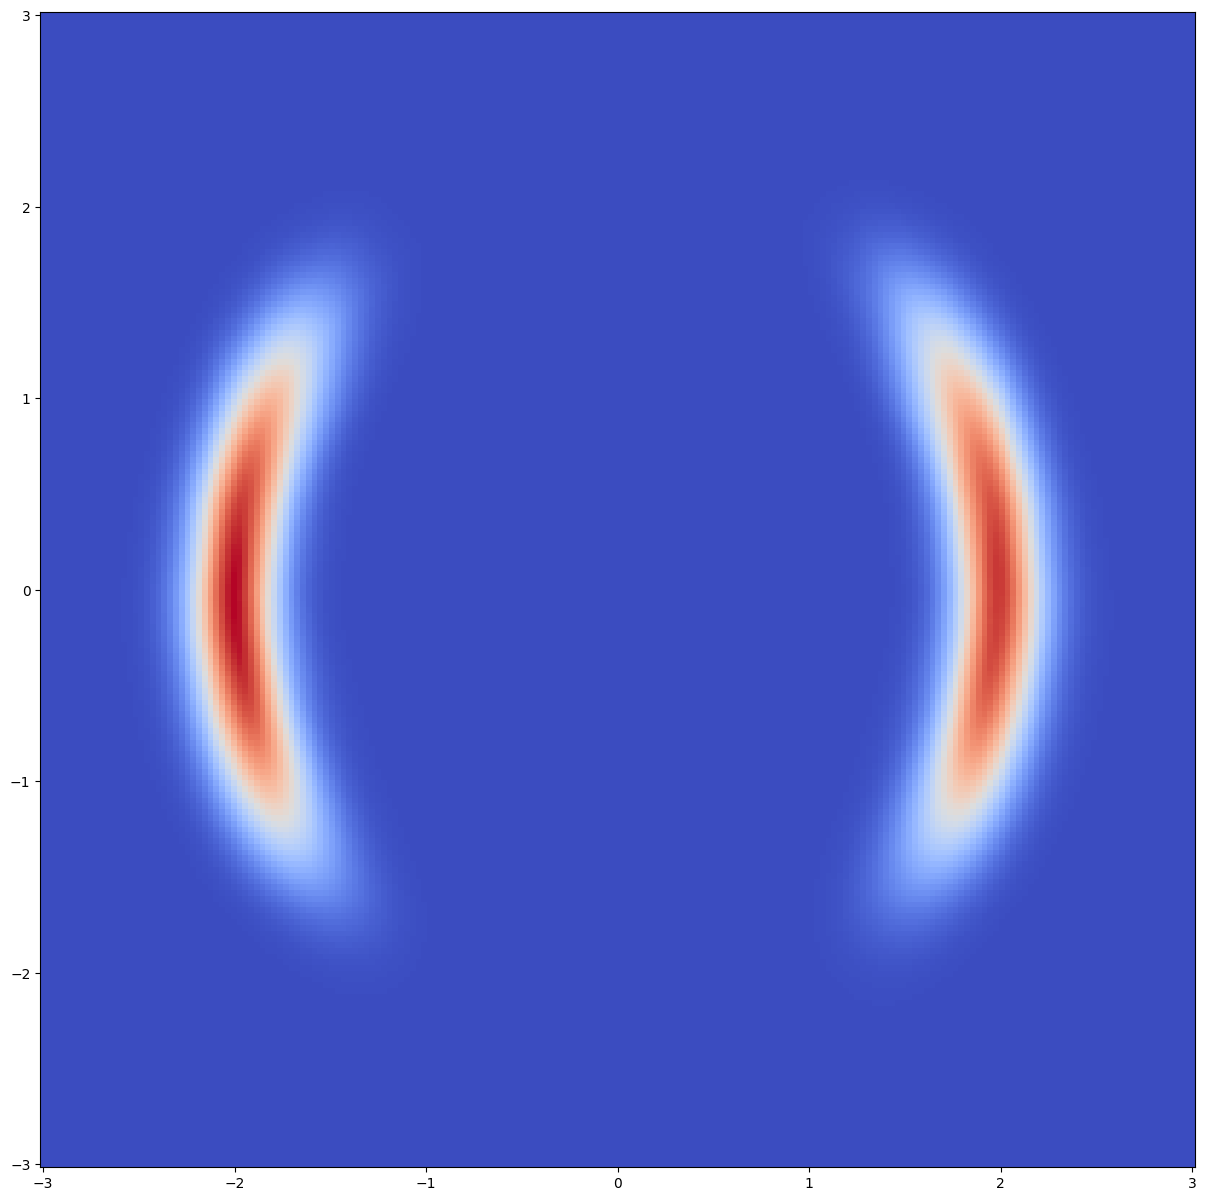

100%|█████████▉| 3999/4000 [10:17<00:00,  6.84it/s]

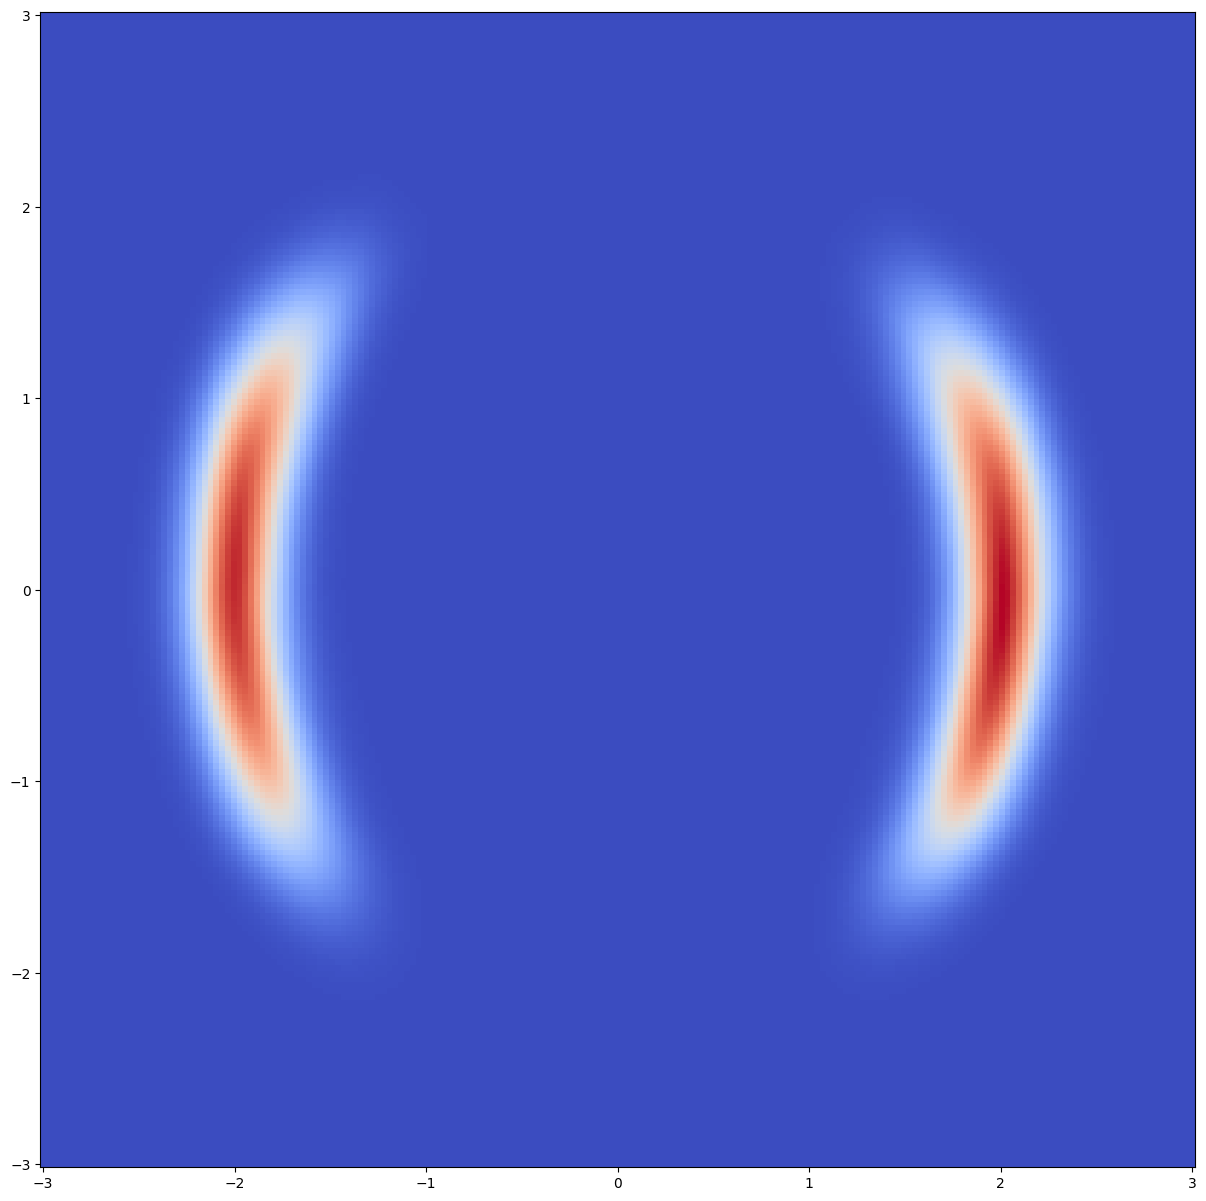

100%|██████████| 4000/4000 [10:20<00:00,  6.45it/s]


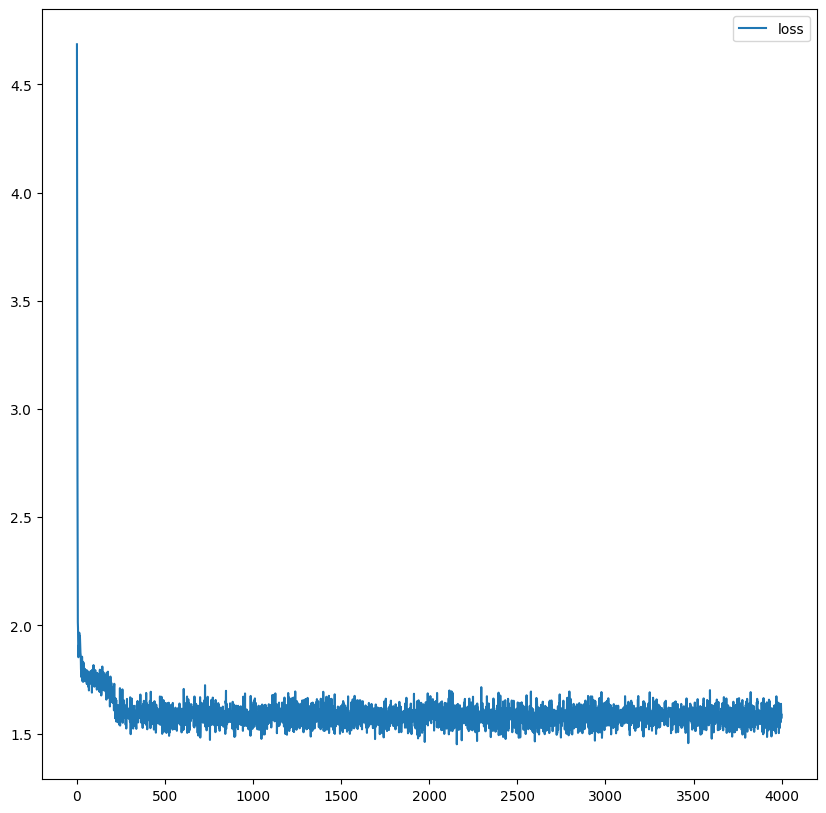

In [12]:
# Train model
max_iter = 4000
num_samples = 2 ** 9
show_iter = 500


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    x = target.sample(num_samples).to(device)
    
    # Compute loss
    loss = model.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

Now the modes are in better shape! And there is no bridge between the two modes!